**This notebook demonstrates application of Grover's algorithm**
$$
   \newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}
   \newcommand{\ket}[1]{\left|{#1}\right\rangle}
   \newcommand{\bra}[1]{\left\langle{#1}\right|}
$$
Grover's algorithm essentially amplifies the amplitude of the desired state within a superposition of states. It is an iterative process:
$$
\ket{\psi_t} = \left(U_sU_f\right)^t\ket{\psi_0}
$$
where the initial state is a uniform decompositon:
$$
\ket{\psi_0} = H^{\otimes n}\ket{0}^n,
$$
$U_f$ is the oracle matrix that selects the target state(s), and $U_s$ implements a rotation that moves the initial state toward to the target state:
$$
U_s = 2\ket{s}\bra{s} - I,
$$
and
$$
D = -W U_s W
$$
where $S$ is the Walsh-Hadamard operator $W = H^{\otimes n}$.

In [2]:
import os, sys
%matplotlib inline
import matplotlib.pyplot as plt
from qiskit import *
from qiskit.compiler import transpile, assemble
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.tools.visualization import plot_histogram

# Import local tools
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import backend_tools

# Get a backend
IBMQ.load_accounts()
device = backend_tools.get_device(use_sim=True, min_qubits=2)

Demonstrate selection of the state $\ket{01}$ (standard notation)

The oracle ($U_f$) for selecting this state is given by:
$$
\left(S \otimes I\right)\left(I \otimes H\right) CNOT_{12} \left(I \otimes H\right)\left(S \otimes I\right)
$$

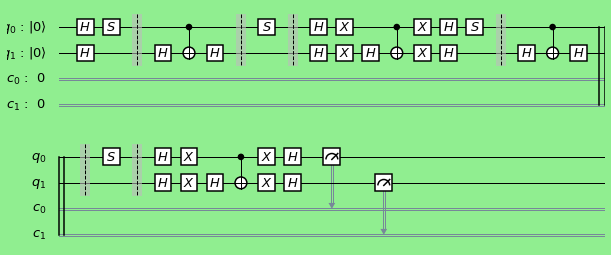

In [13]:
# Define the quantum circuit
q = QuantumRegister(2, 'q')
c = ClassicalRegister(2, 'c')
circuit = QuantumCircuit(q, c)

# Build the initial uniform superposition
circuit.h(q)

# Apply the oracle
oracle = QuantumCircuit(q, c)
oracle.s(q[0])
oracle.barrier()
oracle.h(q[1])
oracle.cx(q[0], q[1])
oracle.h(q[1])
oracle.barrier()
oracle.s(q[0])
oracle.barrier()

# Apply the amplitude amplification
amplify = QuantumCircuit(q, c)
amplify.h(q)
amplify.x(q)
amplify.h(q[1])
amplify.cx(q[0], q[1])
amplify.x(q)
amplify.h(q)

# 1st iteration
circuit += (oracle + amplify)
# 2nd iteration
circuit += (oracle + amplify)

# Finish off with the measurement along the z-axis
circuit.measure(q, c)

# Draw the circuit
style = {'backgroundcolor': 'lightgreen'}
circuit.draw(output='mpl', plot_barriers=True, reverse_bits=False, style=style, scale=0.4)

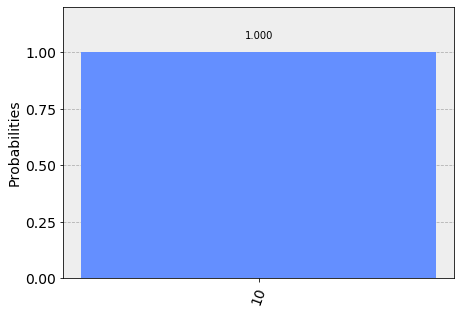

In [14]:
# Simulate or run the circuit
shots = 1024
job = execute(circuit, backend=device, shots=shots)
result = job.result()

# Plot a histogram of the results
counts = result.get_counts(circuit)
plot_histogram(counts)